## Step 0: Setup Environment

In [ ]:
!pip install tensorflow torch torchvision onnx onnxruntime opencv-python matplotlib numpy pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip install mediapipe facenet-pytorch retina-face

In [ ]:
# !unzip archive.zip -d data/


Streaming output truncated to the last 5000 lines.
  inflating: data/train/sad/Training_65242339.jpg  
  inflating: data/train/sad/Training_65267116.jpg  
  inflating: data/train/sad/Training_65275626.jpg  
  inflating: data/train/sad/Training_6529266.jpg  
  inflating: data/train/sad/Training_65329617.jpg  
  inflating: data/train/sad/Training_65338712.jpg  
  inflating: data/train/sad/Training_65338797.jpg  
  inflating: data/train/sad/Training_65387162.jpg  
  inflating: data/train/sad/Training_65404494.jpg  
  inflating: data/train/sad/Training_65426218.jpg  
  inflating: data/train/sad/Training_65430136.jpg  
  inflating: data/train/sad/Training_65437377.jpg  
  inflating: data/train/sad/Training_6545735.jpg  
  inflating: data/train/sad/Training_65463385.jpg  
  inflating: data/train/sad/Training_65473985.jpg  
  inflating: data/train/sad/Training_65502829.jpg  
  inflating: data/train/sad/Training_65505359.jpg  
  inflating: data/train/sad/Training_65508578.jpg  
  inflating: da

## Step 1: Face Detection (BlazeFace)

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
from tqdm import tqdm

# Initialize BlazeFace
mp_face = mp.solutions.face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

def detect_face(image):
    """
    Detects the largest face and returns a cropped 48x48 image.
    If no face is detected, returns a black image.
    """
    results = mp_face.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    h, w, _ = image.shape

    if results.detections:
        bbox = results.detections[0].location_data.relative_bounding_box
        x, y, bw, bh = int(bbox.xmin*w), int(bbox.ymin*h), int(bbox.width*w), int(bbox.height*h)
        x, y = max(0,x), max(0,y)
        cropped = image[y:y+bh, x:x+bw]
        return cv2.resize(cropped, (48,48))
    else:
        return np.zeros((48,48,3), dtype=np.uint8)

def preprocess_dataset(input_dir, output_dir):
    """
    Applies face detection to all images in input_dir and saves cropped images to output_dir.
    """
    for label in os.listdir(input_dir):
        label_in = os.path.join(input_dir, label)
        label_out = os.path.join(output_dir, label)
        os.makedirs(label_out, exist_ok=True)

        for file in tqdm(os.listdir(label_in), desc=f"Processing {label}"):
            img_path = os.path.join(label_in, file)
            img = cv2.imread(img_path)
            face = detect_face(img)
            cv2.imwrite(os.path.join(label_out, file), face)


In [ ]:
# Replace with your actual dataset paths
preprocess_dataset("data/train", "data_cropped/train")
preprocess_dataset("data/test", "data_cropped/test")


Processing happy: 100%|██████████| 1774/1774 [00:09<00:00, 184.05it/s]


## Step 2: Dataset Loading (PyTorch)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Preprocessing: grayscale, tensor, normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder("data_cropped/train", transform=transform)
test_dataset  = datasets.ImageFolder("data_cropped/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = train_dataset.classes
print("Classes:", classes)

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Step 3: Small CNN for Emotion Classification

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 48->24
        x = self.pool(F.relu(self.conv2(x)))  # 24->12
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=len(classes)).to(device)

## Step 4: Training Loop

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")


Epoch 1/15, Loss: 1.6467, Accuracy: 35.06%
Epoch 2/15, Loss: 1.4644, Accuracy: 43.80%
Epoch 3/15, Loss: 1.3803, Accuracy: 47.04%
Epoch 4/15, Loss: 1.3247, Accuracy: 49.47%
Epoch 5/15, Loss: 1.2773, Accuracy: 50.74%
Epoch 6/15, Loss: 1.2358, Accuracy: 52.47%
Epoch 7/15, Loss: 1.1973, Accuracy: 54.04%
Epoch 8/15, Loss: 1.1601, Accuracy: 55.19%
Epoch 9/15, Loss: 1.1257, Accuracy: 56.31%
Epoch 10/15, Loss: 1.0916, Accuracy: 57.87%
Epoch 11/15, Loss: 1.0592, Accuracy: 58.76%
Epoch 12/15, Loss: 1.0359, Accuracy: 59.72%
Epoch 13/15, Loss: 1.0007, Accuracy: 60.87%
Epoch 14/15, Loss: 0.9701, Accuracy: 61.54%
Epoch 15/15, Loss: 0.9414, Accuracy: 62.64%


## Step 5: Evaluate Model

Test Accuracy: 0.5444413485650599


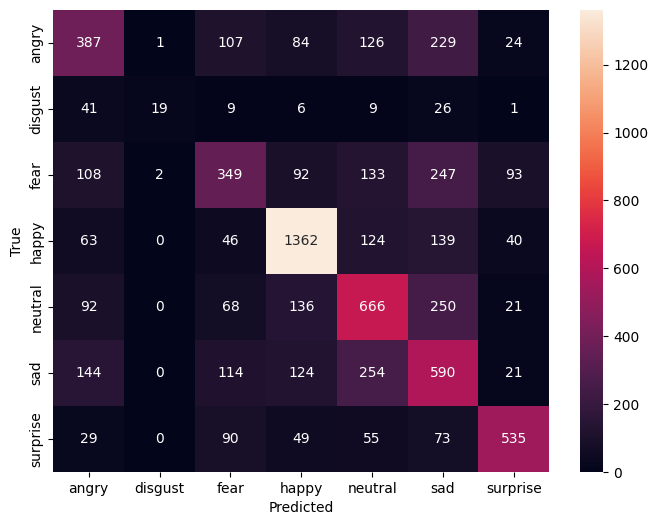

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", acc)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Step 6: Export Model (ONNX)

In [ ]:
dummy_input = torch.randn(1, 1, 48, 48).to(device)
torch.onnx.export(model, dummy_input, "emotion_model.onnx", opset_version=11)
print("ONNX model exported!")


ONNX model exported!


## Step 7: Measure Latency & Model Size

In [ ]:
import time, os

# Latency
model.eval()
sample_images = next(iter(test_loader))[0][:100].to(device)
start = time.time()
for img in sample_images:
    _ = model(img.unsqueeze(0))
latency = (time.time() - start)/len(sample_images)
print("Avg latency per frame (s):", latency)

# Model size
print("ONNX model size (MB):", os.path.getsize("emotion_model.onnx")/1e6)


Avg latency per frame (s): 0.00435536727309227
ONNX model size (MB): 4.799542


## Step 8: Inference on Arbitrary Images / Video

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def predict_emotion(image_path):
    img = cv2.imread(image_path)
    face_crop = detect_face(img)  # Detect and crop face
    face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)  # Convert BGR -> RGB
    face_pil = Image.fromarray(face_crop)  # Convert NumPy -> PIL Image

    face_tensor = transform(face_pil).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(face_tensor)
        _, pred = torch.max(output, 1)
    return classes[pred.item()]

# Example
print(predict_emotion("data/test/sad/PrivateTest_10455506.jpg"))


sad
